Notebook written by Rito showing LPF and resulting interferogram.

Mira

In [1]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.special as ss
%matplotlib inline  

# all values SI
h=6.62606957e-34
c=3e8
kB=1.3806488e-23

# actual planck function here
def Planck_nu(nu,T):
    coef=2.0*h/(c*c)
    x=h*nu/(kB*T)
    y=nu**3
    #ex = math.exp(x)-1.0
    return coef*y*(np.exp(x)-1)**-1

def Planck_sigma(s,T):
    numer = 2*h*s**3
    denom = np.exp(h*c*s/kB/T)-1
    return (numer/denom)

def LPF(sig,nu_c):
    nux = sig*c
    nu_w = np.sqrt(2)*10**10
    temp = 0.5*ss.erfc((nux-nu_c)/nu_w)
    #plt.plot(nux,temp,'.')
    #plt.show()
    return temp

def HPF(sig,nu_c):
    nux = sig*c
    nu_w = np.sqrt(2)*10**10
    temp = 0.5*ss.erfc(-(nux-nu_c)/nu_w)
    #plt.plot(nux,temp,'.')
    #plt.show()
    return temp

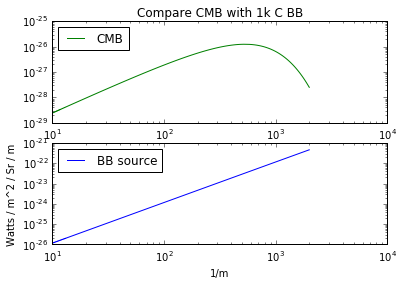

In [2]:
ncell = 2**16
nu_lo = 3*10**9 # 1 GHz
nu_hi = 600*10**9 # GHz
sig_lo = nu_lo/c
sig_hi = nu_hi/c
sig_set = np.linspace(sig_lo, sig_hi, ncell)
dsig = sig_set[1]-sig_set[0]
nu_set = c*sig_set

T_CMB = 2.7 #K
T_BB = 1000+273.0 #K

plt.subplot(2, 1, 1)
plt.step(sig_set, Planck_sigma(sig_set, T_CMB),'-g', label='CMB')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.title('Compare CMB with 1k C BB')
plt.subplot(2, 1, 2)
plt.step(sig_set, Planck_sigma(sig_set, T_BB), label='BB source')
plt.yscale('log')
plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('Watts / m^2 / Sr / m')
plt.xlabel('1/m')
plt.show()

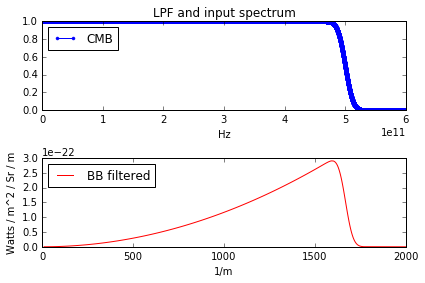

(4096,)


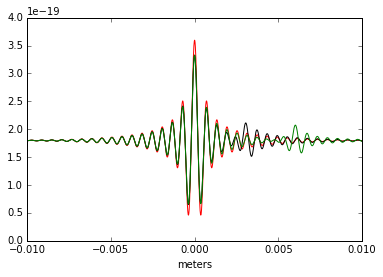

In [3]:
x_hr = 0.01# half range displacement in meters
x_set = np.linspace(-x_hr,x_hr,2**12) # displacement in meters
dx = x_set[2]-x_set[1]
Xrng = np.ptp(x_set)
ghost_frac = 0.15
shiftby_1 = 0.003
shiftby_2 = 0.006

cosarg = 2.0*np.pi*np.outer(sig_set,x_set)
cosarg_shift1 =  2.0*np.pi*np.outer(sig_set,(x_set-shiftby_1))
cosarg_shift2 =  2.0*np.pi*np.outer(sig_set,(x_set-shiftby_2))

nu_cut = 500*10**9# cut off
B_sig0 = Planck_sigma(sig_set, T_BB)

B_sig=B_sig0*LPF(sig_set, nu_cut)

plt.subplot(2, 1, 1)
plt.step(nu_set,LPF(sig_set, nu_cut),'.b', label='CMB')
plt.xlabel('Hz')
plt.legend(loc='upper left')
plt.title('LPF and input spectrum')
plt.subplot(2, 1, 2)
plt.step(sig_set, B_sig,'-r', label='BB filtered')
#plt.yscale('log')
#plt.xscale('log')
plt.legend(loc='upper left')
plt.ylabel('Watts / m^2 / Sr / m')
plt.xlabel('1/m')
plt.tight_layout()
plt.show()


psi_tot = np.sum(B_sig)*dsig

psi0 = psi_tot + np.dot(B_sig, np.cos(cosarg))*dsig

print(np.shape(psi0))

psi1 = psi_tot + (1-ghost_frac)*np.dot(B_sig, np.cos(cosarg))*dsig + ghost_frac*np.dot(B_sig, np.cos(cosarg_shift1))*dsig
psi2 = psi_tot + (1-ghost_frac)*np.dot(B_sig, np.cos(cosarg))*dsig + ghost_frac*np.dot(B_sig, np.cos(cosarg_shift2))*dsig

plt.plot(x_set, psi0, '-r')
plt.plot(x_set, psi1, '-k')
plt.plot(x_set, psi2, '-g')
plt.xlim(-x_hr, x_hr)
plt.xlabel('meters')
plt.show()

v_carr = 10*10**-3 # 10 mm/s

t_set = x_set / v_carr

# plt.plot(t_set, psi0, '-r')
# plt.plot(t_set, psi1, '-k')
# plt.plot(t_set, psi2, '-g')
# plt.xlabel('seconds')
# plt.show()


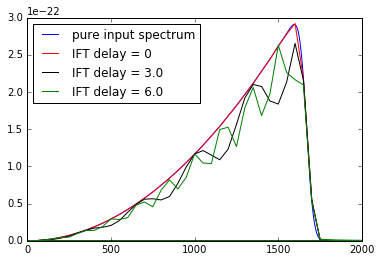

(65536, 4096)


In [4]:
Bft0 = np.fft.fft(psi0-psi_tot)
Nff = len(Bft0)
Bft1 = np.fft.fft(psi1-psi_tot)
Bft2 = np.fft.fft(psi2-psi_tot)

dft_ax = np.fft.fftfreq(len(Bft0))*(1/Xrng)*Nff

plt.plot(sig_set, B_sig,'-b', label='pure input spectrum')
plt.plot(dft_ax, np.abs(Bft0)*dx*2, 'r', label='IFT delay = 0')
plt.plot(dft_ax, np.abs(Bft1)*dx*2, 'k', label='IFT delay = '+str(shiftby_1*10**3))
plt.plot(dft_ax, np.abs(Bft2)*dx*2, 'g', label='IFT delay = '+str(shiftby_2*10**3))
plt.xlim(0,sig_hi)
plt.legend(loc='upper left')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('1/m')
plt.show()

print(len(B_sig), len(dft_ax))

In [13]:
len(dft_ax[dft_ax<sig_hi])

2088

In [6]:
sig_hi

2000.0

In [7]:
ff = np.arange(0,1/dx,1/Xrng)

In [8]:
print(len(ff))*2

8192


In [9]:
print(len(Bft0))

4096


In [10]:
0.78*(2**15)

25559.04

In [11]:
0.5*1/dx

102375.00000000182